In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import time
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

os.environ["KERAS_BACKEND"] = "torch"
import keras_core as keras
import keras

Using PyTorch backend.


It sets 10 classes and a (28,28,1) input, loads Fashion-MNIST, scales pixels to [0,1], adds a channel dimension to get (N,28,28,1), prints dataset sizes, and one-hot encodes labels for use with categorical cross-entropy.

In [2]:

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Let's print some images from the dataset

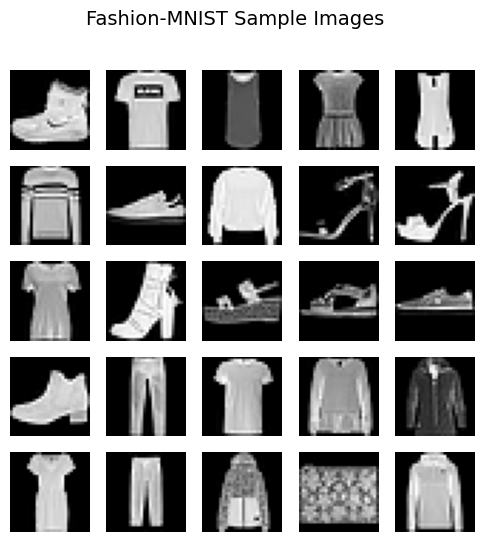

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Show 25 samples from the training set
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Fashion-MNIST Sample Images", fontsize=14)
plt.show()


This builds a CNN with three Conv–BatchNorm–ReLU + MaxPool blocks (32/64/128 filters, same padding), then GlobalAveragePooling, Dropout, a 128-unit Dense layer, and a softmax output to classify images into num_classes.

In [16]:
from tensorflow import keras

model = keras.Sequential([
    keras.Input(shape=input_shape),

    keras.layers.Conv2D(32, (3,3), padding="same", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), padding="same", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), padding="same", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax"),
])


In [17]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 7, 7, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,146 (434.16 KB)

 Trainable params: 110,698 (432.41 KB)

 Non-trainable params: 448 (1.75 KB)

Chooses Adam(0.001) as the optimizer (others commented), compiles the model with categorical_crossentropy and accuracy, then trains on x_train/y_train for 15 epochs with batch size 128 and a 10% validation split.

In [18]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import SGD, Adam, Adamax, Nadam, RMSprop, Adagrad, Adadelta, Ftrl
batch_size = 128
epochs = 15

# Modify the optimizer here
#optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizer = Adam(learning_rate=0.001)
#optimizer = Adadelta(learning_rate=1.0)
#optimizer = Nadam(learning_rate=0.002)
#optimizer = RMSprop(learning_rate=0.001)


model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])   #keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=1e-6, nesterov=True)

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6343 - loss: 1.0164 - val_accuracy: 0.5852 - val_loss: 1.1540
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8336 - loss: 0.4634 - val_accuracy: 0.8343 - val_loss: 0.4550
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8621 - loss: 0.3884 - val_accuracy: 0.8465 - val_loss: 0.4147
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8732 - loss: 0.3534 - val_accuracy: 0.8900 - val_loss: 0.3062
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8819 - loss: 0.3284 - val_accuracy: 0.8893 - val_loss: 0.2914
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8912 - loss: 0.3052 - val_accuracy: 0.8978 - val_loss: 0.2757
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8980 - loss: 0.2835 - val_accuracy: 0.9028 - val_loss: 0.2644
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9018 - loss: 0.2743 - val_accu

Evaluates the trained model on the test set (silently) and prints the resulting loss and accuracy.

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.23134110867977142
Test accuracy: 0.914900004863739


Generates predictions on the test set, converts them to label indices, randomly selects 16 test images, and displays a 4×4 grid showing each image with Predicted (P) vs True (T) labels—colored green if correct and red if incorrect.

  1/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


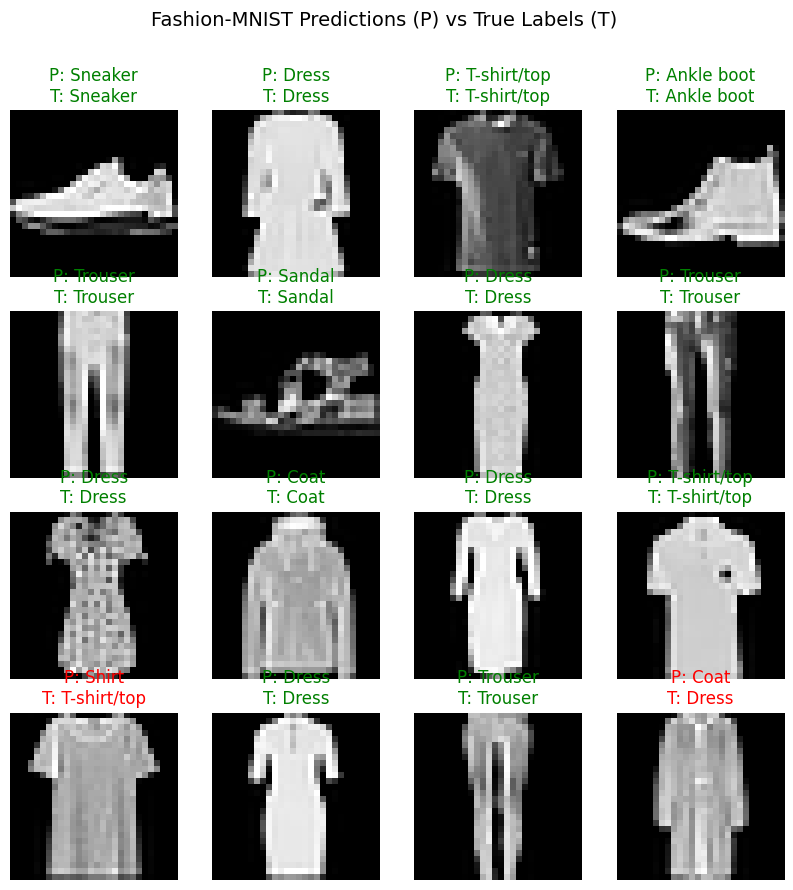

In [15]:
import matplotlib.pyplot as plt
import numpy as np
class_names = [
    "T-shirt/top",  # 0
    "Trouser",      # 1
    "Pullover",     # 2
    "Dress",        # 3
    "Coat",         # 4
    "Sandal",       # 5
    "Shirt",        # 6
    "Sneaker",      # 7
    "Bag",          # 8
    "Ankle boot"    # 9
]


# Get predictions on test data
y_pred = model.predict(x_test)

# Convert one-hot back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Pick some random test images
num_samples = 16
indices = np.random.choice(len(x_test), num_samples, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[idx].squeeze(), cmap="gray")
    plt.axis("off")
    
    # Show predicted vs actual
    plt.title(f"P: {class_names[y_pred_classes[idx]]}\nT: {class_names[y_test_classes[idx]]}",
          color="green" if y_pred_classes[idx] == y_test_classes[idx] else "red")


plt.suptitle("Fashion-MNIST Predictions (P) vs True Labels (T)", fontsize=14)
plt.show()


Computes a confusion matrix from predictions, plots both the raw-count and row-normalized versions, and prints a classification report (precision, recall, F1, support) for each class.

A confusion matrix is a table that provides a detailed breakdown of a classification model's performance by showing the number of correct and incorrect predictions for each class. It's a fundamental tool for evaluating the performance of machine learning models on a set of test data where the true values are known.

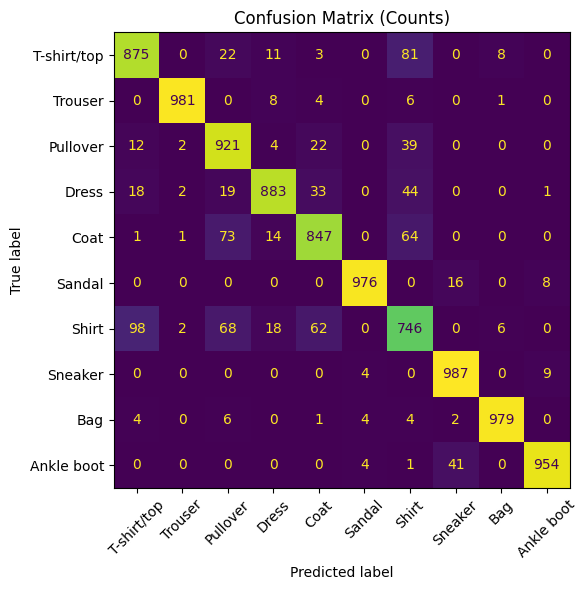

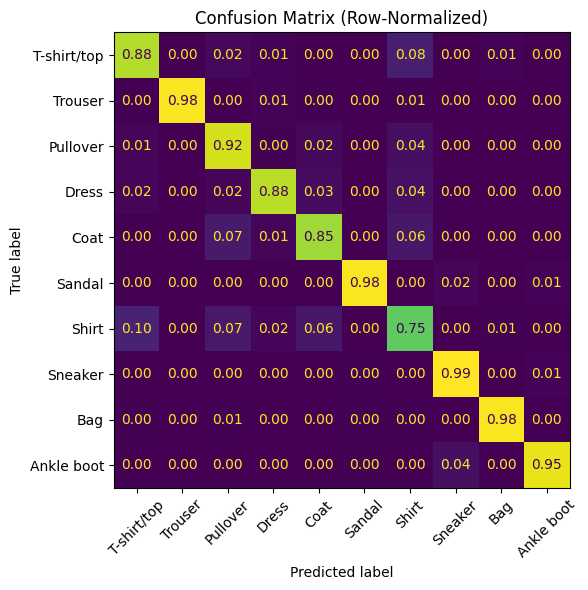

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.83      0.92      0.87      1000
       Dress       0.94      0.88      0.91      1000
        Coat       0.87      0.85      0.86      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.76      0.75      0.75      1000
     Sneaker       0.94      0.99      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Confusion matrix (counts)
cm = confusion_matrix(y_test_classes, y_pred_classes, labels=range(len(class_names)))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, values_format='d', colorbar=False, xticks_rotation=45)
ax.set_title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

# Normalized confusion matrix (per true class)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp.plot(ax=ax, values_format='.2f', colorbar=False, xticks_rotation=45)
ax.set_title("Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))
